---

_You are currently looking at **version 1.1** of this notebook. To download notebooks and datafiles, as well as get help on Jupyter notebooks in the Coursera platform, visit the [Jupyter Notebook FAQ](https://www.coursera.org/learn/python-machine-learning/resources/bANLa) course resource._

---

## Understanding and Predicting Property Maintenance Fines

This project is based on a data challenge from the Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)). 

The Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)) and the Michigan Student Symposium for Interdisciplinary Statistical Sciences ([MSSISS](https://sites.lsa.umich.edu/mssiss/)) have partnered with the City of Detroit to help solve one of the most pressing problems facing Detroit - blight. [Blight violations](http://www.detroitmi.gov/How-Do-I/Report/Blight-Complaint-FAQs) are issued by the city to individuals who allow their properties to remain in a deteriorated condition. Every year, the city of Detroit issues millions of dollars in fines to residents and every year, many of these fines remain unpaid. Enforcing unpaid blight fines is a costly and tedious process, so the city wants to know: how can we increase blight ticket compliance?


All data for this assignment has been provided through the [Detroit Open Data Portal](https://data.detroitmi.gov/).

___


<br>

**File descriptions** 

    readonly/train.csv - the training set (all tickets issued 2004-2011)
    readonly/test.csv - the test set (all tickets issued 2012-2016)
    readonly/addresses.csv & readonly/latlons.csv - mapping from ticket id to addresses, and from addresses to lat/lon coordinates. 
     Note: misspelled addresses may be incorrectly geolocated.

<br>

**Data fields**

train.csv & test.csv

    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee - $20 fee assigned to responsible judgments
state_fee - $10 fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations
    
train.csv only

    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction] 
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant




In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
    
dataset = pd.read_csv('train.csv', encoding = 'ISO-8859-1')


# let's explore the data first
# We count how many instances of each class we have in the original dataset

counts = dataset["compliance"].value_counts() # only counts numeric values (i.e will miss N.a.N)
NR_counts = len(dataset) - (counts[0] + counts[1])

print('The original dataset has shape: {}'.format(np.shape(dataset)))
print('The class distribution is: <{} non responsible>, <{} compliant> and <{} non compliant>'.\
      format(NR_counts, counts[1], counts[0]))#print()

print()

# We remove tickets that were considered not valid (i.e we don't know the label)
dataset = dataset.dropna(subset=['compliance'])
print('After removing non responsible tickets: {}'.format(np.shape(dataset)))

# We remove entries of people that have invalid zip_codes
dataset['zip_code'] = pd.to_numeric(dataset['zip_code'], errors = 'coerce')
dataset = dataset.dropna(subset=['zip_code'])
    
# We remove people not living in detroit
dataset['zip_code'] = dataset['zip_code'].astype(str)
dataset = dataset[(dataset['zip_code'].str.len() == 7)]
bool_mask = dataset['zip_code'].apply(lambda x: True if x[0] == '4' else False)
dataset = dataset[bool_mask]
                                              

    
# Now we can create our training and testing split  
X = dataset.drop(columns = 'compliance')
y = dataset['compliance']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

num_features = ['fine_amount', 'judgment_amount','discount_amount', 'clean_up_cost']
cat_features = ['disposition', 'zip_code']

X_train = X_train[num_features + cat_features]
X_test = X_test[num_features + cat_features]
   
# Now we transform categorical variables 'disposition', 'zip_code', into one hot encoded features
one_hot_encoding = pd.get_dummies(X_train[cat_features])
X_train = pd.concat([X_train[num_features], one_hot_encoding], axis=1)
    
one_hot_encoding_test = pd.get_dummies(X_test[cat_features])
X_test = pd.concat([X_test[num_features], one_hot_encoding_test], axis=1)

    
print('Training dataset shape before alignment: {}'.format(np.shape(X_train)))
print('Testing dataset shape before alignment: {}'.format(np.shape(X_test)))
    
X_train, X_test = X_train.align(X_test, join='inner', axis=1)

print('Training dataset shape after alignment: {}'.format(np.shape(X_train)))
print('Testing dataset shape after alignment: {}'.format(np.shape(X_test)))

print()
    
####################################################################################################
## block when optimizing for parameters

parameters = {'n_estimators': [100,1000], 'max_depth':[10,15,20]}
RF = RandomForestClassifier()
# we perform a search with the auc parameter because of the class imbalance. 
clf_grid_auc = GridSearchCV(RF, parameters, cv = 3, scoring = 'roc_auc')
clf_grid_auc.fit(X_train, y_train)
#print(clf_grid_auc.cv_results_)
    
print('Grid best parameters (best AUC): {}'.format(clf_grid_auc.best_params_))
print('Grid best AUC: {}'.format(clf_grid_auc.best_score_))
    
probas = clf_grid_auc.predict_proba(X_test)
predicted = probas[:,1]
AUC_score = roc_auc_score(y_test, predicted)
print('AUC score on test set: {}'.format(AUC_score))

# comparing our AUC score with dummy classifier

dummy = DummyClassifier(strategy='stratified').fit(X_train, y_train)
predicted = dummy.predict(X_test)
AUC_dummy = roc_auc_score(y_test, predicted)
print('Dummy classifier AUC on testset: {}'.format(AUC_dummy))


#####################################################################################################
# Here we know which parameters work best : used for testing or submiting

#RF = RandomForestClassifier(max_depth=15, n_estimators=1000).fit(X_train, y_train)
#predicted = RF.predict_proba(X_train)
#predicted = predicted[:,1] #we only keep prediciton for the positive class
#AUC_score = roc_auc_score(y_train, predicted)
#print('AUC score on training set: {}'.format(AUC_score))
#probas = RF.predict_proba(X_test)
    
 

The original dataset has shape: (250306, 34)
The class distribution is: <90426 non responsible>, <11597 compliant> and <148283 non compliant>
After removing non responsible tickets: (159880, 34)
Training dataset shape before alignment: (107721, 743)
Testing dataset shape before alignment: (35907, 547)
Training dataset shape after alignment: (107721, 475)
Testing dataset shape after alignment: (35907, 475)
Grid best parameters (best AUC): {'max_depth': 15, 'n_estimators': 1000}
Grid best AUC: 0.804753619392012
AUC score on test set: 0.8115665253692019


## RandomForest evaluation

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=15, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


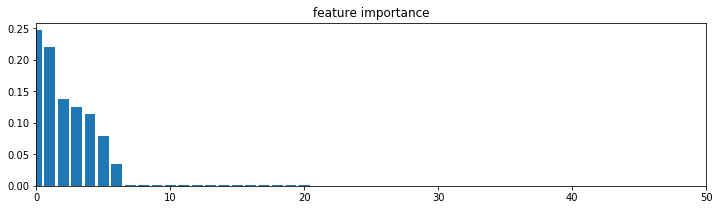

the 10 most important features are:
Index(['disposition_Responsible by Default', 'discount_amount',
       'judgment_amount', 'disposition_Responsible by Admission',
       'disposition_Responsible by Determination', 'fine_amount',
       'disposition_Responsible (Fine Waived) by Deter', 'zip_code_48037.0',
       'zip_code_48216.0', 'zip_code_48209.0'],
      dtype='object')


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
  
# We plot the feature importances returned by our ensemble of trees

estimator = clf_grid_auc.best_estimator_
print(estimator)
importance = estimator.feature_importances_

std = np.std([tree.feature_importances_ for tree in estimator.estimators_])
indices = np.argsort(importance)[::-1] # put indice in descending order

plt.figure(figsize=(12,3))
plt.title('feature importance')
plt.bar(range(len(X_train.columns)), importance[indices])
plt.xlim([0,50])
plt.show()

# from plot we can try to chose better features by only taking the n most important features
n=10 # 10 most important features are retained
imp_features = X_train.columns[indices[:n]]

print('the 10 most important features are:')
print(imp_features)

### New model creation with our feature selection approach

In [27]:
X_train = X_train[imp_features]
X_test = X_test[imp_features]

parameters = {'n_estimators': [100,1000], 'max_depth':[10,15,20]}
RF_2 = RandomForestClassifier()
# we perform a search with the auc parameter because of the class imbalance. 
clf_grid_auc_2 = GridSearchCV(RF_2, parameters, cv = 3, scoring = 'roc_auc')
clf_grid_auc_2.fit(X_train, y_train)
#print(clf_grid_auc.cv_results_)
    
print('Grid best parameters (best AUC): {}'.format(clf_grid_auc_2.best_params_))
print('Grid best AUC: {}'.format(clf_grid_auc_2.best_score_))
    
probas = clf_grid_auc_2.predict_proba(X_test)
predicted = probas[:,1]
AUC_score = roc_auc_score(y_test, predicted)
print('AUC score on test set: {}'.format(AUC_score))

# comparing our AUC score with dummy classifier

dummy = DummyClassifier(strategy='stratified').fit(X_train, y_train)
predicted = dummy.predict(X_test)
AUC_dummy = roc_auc_score(y_test, predicted)
print('Dummy classifier AUC on testset: {}'.format(AUC_dummy))


Grid best parameters (best AUC): {'max_depth': 15, 'n_estimators': 1000}
Grid best AUC: 0.800666987628207
AUC score on test set: 0.8082308955820587
Dummy classifier AUC on testset: 0.5016284645613363
